# Predicting digit images

## Importing required libraries

In [655]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import svm


## Download data

In [402]:
df = pd.read_csv('digit-recognizer/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualize the digits

In [55]:
#df.loc[:,df.columns!='label'] = np.ceil((df.loc[:,df.columns!='label'])/100)

In [87]:
#df.loc[:,df.columns!='label'] = (df.loc[:,df.columns!='label']> 0)

In [ ]:
## Visualize 16 digits randomly

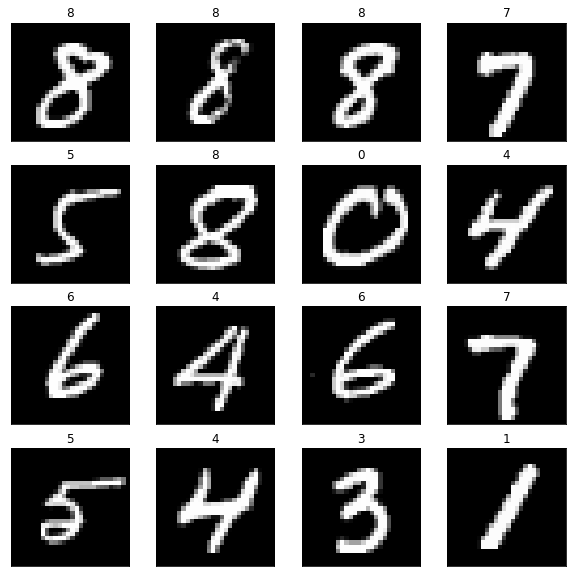

In [192]:
labels = df['label']
l = np.random.randint(df.shape[0],size = 16)
plt_labels = labels[l]
plt_images = df.iloc[l].filter(like='pixel').to_numpy().reshape(-1, 28, 28, 1)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for image, label, ax in zip(plt_images, plt_labels, axes.ravel()):
    ax.imshow(image,cmap='gray', vmin=0, vmax=255)
    ax.set(title=label, xticks=[], yticks=[])

In [97]:
df_test = pd.read_csv('digit-recognizer/test.csv')
#df_test = (df_test> 0)

In [199]:
start_time = time.time()
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5],
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)



accuracy_score(y_hat_test_RF,y_test)

prediction = rf_grid_search.predict(scaler.fit_transform(df_test))

prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission.csv',index=False)
print(time.time()-start_time)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 95.78%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9596428571428571}
331.4619212150574


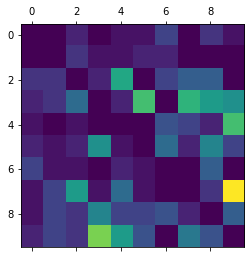

In [215]:
a = np.zeros([10,10],int)
np.fill_diagonal(a,np.diag(confusion_matrix(y_test,y_hat_test_RF)))
plt.matshow(confusion_matrix(y_test,y_hat_test_RF)-a)

In [230]:
np.diagonal(confusion_matrix(y_test,y_hat_test_RF))/np.array(y_test.value_counts().sort_index())

array([0.98529412, 0.99009901, 0.95744681, 0.93383138, 0.96781883,
       0.94586895, 0.98089172, 0.9462486 , 0.95449102, 0.93556086])

As we can see 3 and 9 are pretty poorly predicted as are 5,7 and 8  Lets serr if we can do any better

### Trying one vs all classification Random Forest

In [233]:
start_time = time.time()
y = (df['label']==3)
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5],
            'class_weight': ["balanced"]
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)
print(time.time()-start_time)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 98.60%

Optimal Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9854761904761905}
261.70926094055176


It seems the accuracy has increased. Now lets see if we can do ove vs all classification on all classes

In [243]:
grid_search_result = []
prob_array = []
for label in range(10):
    print('Analyzing:', label)
    y = (df['label']==label)
    scaler = StandardScaler()
    X = scaler.fit_transform(df.drop(['label'],axis=1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

    rf_clf = RandomForestClassifier()
    rf_param_grid = {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 2, 3, 5,10],
                'min_samples_split': [None,5,10],
                'min_samples_leaf': [None,3,5],
                'class_weight': ["balanced"]
            }
    rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
    rf_grid_search.fit(X_train, y_train)

    grid_search_result.append(rf_grid_search)
    
    y_hat_test_RF = rf_grid_search.predict_proba(X_test)[:,1]
    prob_array.append(y_hat_test_RF)

Analyzing: 0
Analyzing: 1
Analyzing: 2
Analyzing: 3
Analyzing: 4
Analyzing: 5
Analyzing: 6
Analyzing: 7
Analyzing: 8
Analyzing: 9


In [256]:
np.argmax(np.array(prob_array),axis=0)

array([8, 1, 9, ..., 3, 0, 9])

In [258]:
y = df['label']
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

In [259]:
y_test

5457     8
38509    1
25536    9
31803    9
39863    8
        ..
8388     4
29359    9
40276    3
18421    0
4335     9
Name: label, Length: 8400, dtype: int64

In [262]:
(np.argmax(np.array(prob_array),axis=0) ==y_test).sum()/y_test.shape[0]

0.96

### Feeding row by row correlation

In [342]:
df_zeros = df[df.label==0]
df_ones = df[df.label == 1]

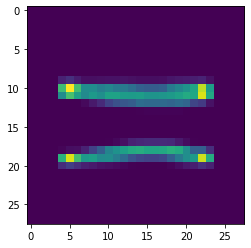

In [347]:
plt.imshow(np.matmul(df_zeros.iloc[7].filter(like='pixel').to_numpy().reshape(-1,28,28),df_zeros.iloc[7].filter(like='pixel').to_numpy().reshape(-1,28,28).T))

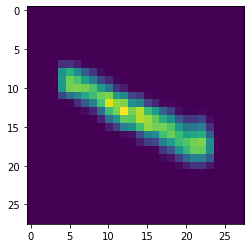

In [295]:
plt.imshow(np.matmul(df_ones.iloc[0].filter(like='pixel').to_numpy().reshape(-1,28,28),df_ones.iloc[0].filter(like='pixel').to_numpy().reshape(-1,28,28).T))

In [318]:
np.zeros([df_zeros.shape[0],df_zeros.shape[1]]).shape

(4132, 785)

In [319]:
df_zeros_final = pd.DataFrame(np.zeros([df_zeros.shape[0],df_zeros.shape[1]]))

df_zeros_final.columns = df.columns

df_zeros_final['label'] = df_zeros['label']

In [355]:
df_ones_final = pd.DataFrame(np.zeros([df_ones.shape[0],df_ones.shape[1]]))

df_ones_final.columns = df.columns

df_ones_final['label'] = df_ones['label']

In [394]:
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [413]:
df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [445]:
df_corr = pd.DataFrame()
for l in range(10):
    print(l)
    df_l = df[df.label==l]
    #print(df_l.head())
    df_l_final = pd.DataFrame(np.zeros([df_l.shape[0],df_l.shape[1]]))
    df_l_final.columns = df_l.columns
    #df_l_final['label'] = l
    #print(df_l_final.head())
    for i in range(df_l.shape[0]):
        mat = df_l.iloc[i].filter(like='pixel').to_numpy().reshape(-1,28,28)
        df_l_final.iloc[i]= np.append(l,np.matmul(mat,mat.T).flatten())
        #print(df_l_final.iloc[0].sum())
    print(df_l_final.iloc[i][1:].sum())
    df_corr = df_corr.append(df_l_final)

0
45264183.0
1
11657527.0
2
41706609.0
3
19749352.0
4
42458002.0
5
34975038.0
6
39837674.0
7
42951459.0
8
20915833.0
9
23071358.0


In [406]:
df_corr

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4183,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4184,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4185,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4186,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [556]:
df_corr['label'].iloc[l]

777     8.0
825     5.0
930     6.0
770     3.0
1572    5.0
2570    9.0
113     6.0
2112    2.0
692     4.0
709     9.0
2721    6.0
1707    8.0
527     6.0
4044    7.0
4467    1.0
463     7.0
Name: label, dtype: float64

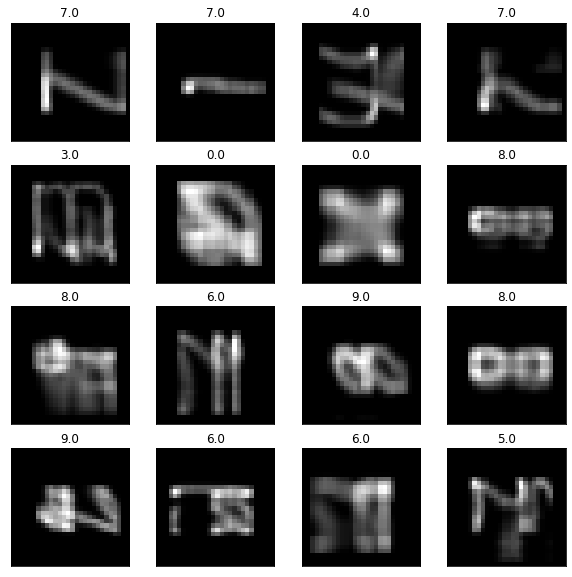

In [559]:
labels = df_corr['label']
l = np.random.randint(df_corr.shape[0],size = 16)
plt_labels = df_corr['label'].iloc[l]
plt_images = df_corr.iloc[l].filter(like='pixel').to_numpy().reshape(-1, 28, 28, 1)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for image, label, ax in zip(plt_images, plt_labels, axes.ravel()):
    ax.imshow(image,cmap='gray')
    ax.set(title=label, xticks=[], yticks=[])

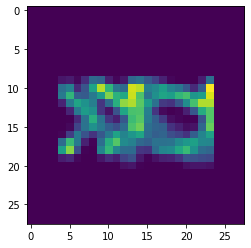

In [463]:
plt.imshow(df_corr.iloc[35000].filter(like='pixel').to_numpy().reshape(-1,28,28)[0])

In [653]:
start_time = time.time()
y = df_corr['label']
scaler = StandardScaler()
X = scaler.fit_transform(df_corr.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

rf = RandomForestRegressor()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5],
        }
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")


print(time.time()-start_time)

NameError: name 'RandomForestRegressor' is not defined

## SVM

In [466]:
start_time = time.time()
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

svm_clf = svm.SVC(kernel='rbf')
#r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  ['auto','scale']
C_range = [0.01,0.1,1,10,100]
#d_range = np.array([2,3, 4])
param_grid = dict(C = C_range, gamma=gamma_range,probability = [True])
svm_grid_search = GridSearchCV(svm_clf, param_grid, cv=5,n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
best_svm = svm_grid_search.best_params_
y_hat_test_svm = svm_grid_search.predict(X_test)
svm_proba = svm_grid_search.predict_proba(X_test)
SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test)}
print(SVM_poly_dict)
print(time.time()-start_time)

{'accuracy': 0.9655952380952381}
19967.788126945496


In [ ]:
#### SVM took 20,000 secs to run and gives an accuracy of 0.965

In [467]:
prediction = svm_grid_search.predict(scaler.fit_transform(df_test))
prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission_svm.csv',index=False)

## SVD

### Performing SVD

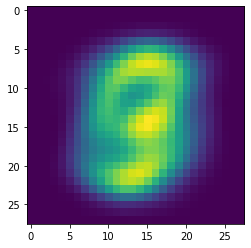

In [513]:
y = df['label']
digits = df.drop(['label'],axis=1).to_numpy().T/255
digitsavg = np.mean(digits,axis=1)

XPCA = digits - np.tile(digitsavg.reshape(-1,1).T,(digits.shape[1],1)).T
plt.imshow(digitsavg.reshape(28,28))

In [566]:
(S[:700].cumsum()/S[:700].sum()< 0.90).sum()

349

Text(0, 0.5, 'variance')

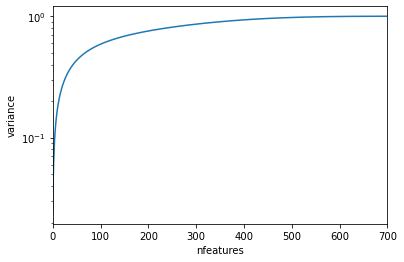

In [562]:
U,S,VT = np.linalg.svd(XPCA,full_matrices=0)

plt.plot(S[:700].cumsum()/S[:700].sum())
plt.yscale('log')
plt.xlim([0,700])
plt.xlabel('nfeatures')
plt.ylabel('variance')

In [ ]:
### Visulally maybe first 200 enties will suffice. Let's check it out by reconstructing

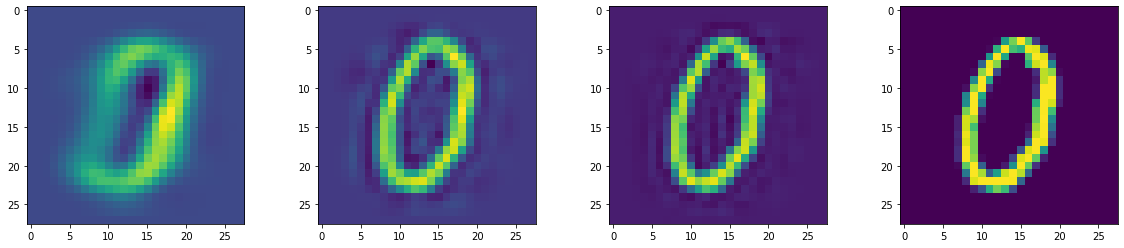

In [517]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
for ix,r in enumerate([10,100,200,784]):
    ax[ix].imshow((U[:,:r] @U[:,:r].T @XPCA[:,5]+ digitsavg).reshape(28,28))

In [534]:
r = 200
X = scaler.fit_transform((U[:,:r].T @ XPCA).T)

#### Running RF on SVD dataset

In [533]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5]
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=2,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)



accuracy_score(y_hat_test_RF,y_test)

print(time.time()-start_time)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 89.82%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9147619047619048}
609.6415529251099


In [ ]:
#### Running SVM on transformed data

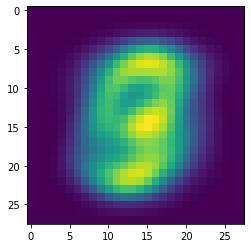

In [545]:
digits_sub = df_test.to_numpy().T/255
digitsavg_sub = np.mean(digits_sub,axis=1)

XPCA_sub = digits_sub - np.tile(digitsavg_sub.reshape(-1,1).T,(digits_sub.shape[1],1)).T
plt.imshow(digitsavg_sub.reshape(28,28))
X_sub = scaler.fit_transform((U[:,:r].T @ XPCA_sub).T)

In [546]:
X_sub.shape

(28000, 200)

In [536]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

svm_clf = svm.SVC(kernel='rbf')
#r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  ['auto','scale']
C_range = [0.01,0.1,1,10,100]
#d_range = np.array([2,3, 4])
param_grid = dict(C = C_range, gamma=gamma_range,probability = [True])
svm_grid_search = GridSearchCV(svm_clf, param_grid, cv=2,n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
best_svm = svm_grid_search.best_params_
y_hat_test_svm = svm_grid_search.predict(X_test)
svm_proba_SVD_200 = svm_grid_search.predict_proba(X_test)
SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test)}
print(SVM_poly_dict)
print(time.time()-start_time)

{'accuracy': 0.9721428571428572}
2749.6019399166107


In [547]:
prediction = svm_grid_search.predict(scaler.fit_transform(X_sub))
prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission_svm.csv',index=False)

### XGB

In [549]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

estimator = XGBClassifier(
objective= 'multi:softmax',
        nthread=2,
        seed=42)
parameters = {
            'max_depth': range (2, 10, 2),
            'n_estimators': range(20, 120, 20),
            'learning_rate': [0.001,0.01, 0.1]
        }
xgb_grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=parameters,
            n_jobs = -1,
            cv = 2,
            verbose=False
        )
xgb_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
xgb_best = xgb_grid_search.best_params_
y_hat_test_XGB = xgb_grid_search.predict(X_test)
XGB_dict = {'accuracy':accuracy_score(y_hat_test_XGB,y_test)}

print(XGB_dict)
print(time.time()-start_time)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 93.41%

Optimal Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
{'accuracy': 0.9483333333333334}
4366.7500920295715


array([[815,   0,   2,   0,   0,   2,   4,   0,   5,   0],
       [  0, 933,   6,   4,   1,   0,   1,   3,   3,   0],
       [  2,   3, 804,   2,   4,   0,   4,   6,   5,   2],
       [  6,   0,  13, 814,   1,  13,   2,   6,  18,   7],
       [  2,   1,   0,   0, 791,   0,   4,   2,   2,  13],
       [  5,   3,   1,   9,   1, 746,   3,   0,   6,   3],
       [  5,   2,   0,   0,   2,   4, 794,   0,   1,   0],
       [  1,   1,  10,   0,   6,   0,   0, 876,   3,  13],
       [  2,   1,   4,   9,   4,   9,   3,   0, 762,   9],
       [  7,   2,   1,  12,  19,   4,   1,   7,   4, 739]])

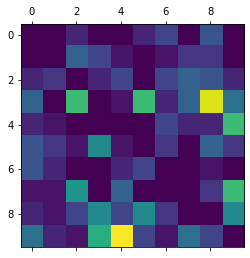

In [125]:
c = confusion_matrix(y_test,y_hat_test_RF)
a = np.zeros([10,10])
np.fill_diagonal(a, c.diagonal()) 
plt.matshow(c-a)

## Performing a SVD

In [183]:
y = df['label']
digits = df.drop(['label'],axis=1).to_numpy().T/255
digitsavg = np.mean(digits,axis=1)

X = digits - np.tile(digitsavg.reshape(-1,1).T,(digits.shape[1],1)).T

In [224]:
X[:,1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.17647059e-05, -4.38842204e-05, -2.01680672e-05, -8.40336134e-07,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.49393091e-06, -5.13538749e-06, -4.13632120e-05, -1.06909430e-04,
       -1.99626517e-04, -2.60410831e-04, -5.08123249e-04, -6.82819795e-04,
       -7.50233427e-04, -7.47432306e-04, -7.68814192e-04, -6.71988796e-04,
       -6.45004669e-04, -5.94957983e-04, -4.12978525e-04, -2.38375350e-04,
       -1.76750700e-04, -6.04108310e-05, -4.12698413e-05, -1.97945845e-05,
        0.00000000e+00,  

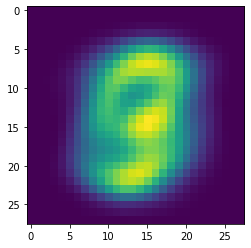

In [185]:
plt.imshow(digitsavg.reshape(28,28))

In [186]:
U,S,VT = np.linalg.svd(X,full_matrices=0)

plt.plot(S)
plt.yscale('log')

In [ ]:
## Now lets see how it does on a test set

In [13]:
df_test = pd.read_csv('digit-recognizer/test.csv')
#y_test = df_test['label']
#X_test = df_test.drop(['label'],axis=1).T
#X_test = df_test.T.to_numpy()/255

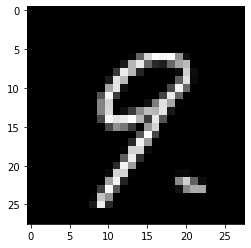

In [189]:
plt.imshow(X_test[:,2].reshape(28,28),cmap='gray')

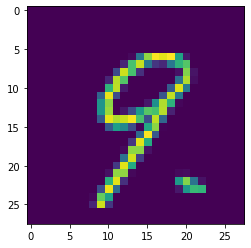

In [190]:
r = 784
plt.imshow((U[:,:r] @U[:,:r].T @X_test[:,2]).reshape(28,28))

In [ ]:
## Plotting Correlations between principle components

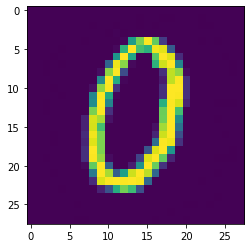

In [220]:
r = 500
plt.imshow((U[:,:r] @U[:,:r].T @X[:,5]+ digitsavg).reshape(28,28))

In [216]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

1

In [241]:
XSVD[0][0]

(4132,)

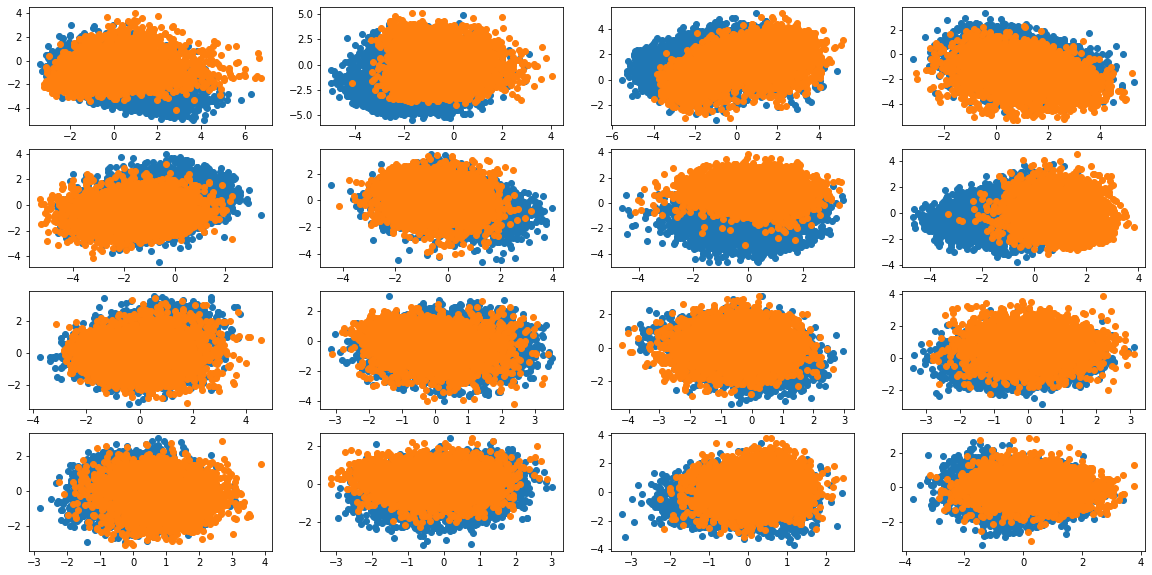

In [276]:
r = 100
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
XSVD = []
for i in range(10):
    select = labels==i
    Xplot = X[:,select]
    XSVD.append(U[:,:r].T @ Xplot)
    #print(XSVD.shape)
    for j in range(0,16):
        if i in [3,8]:
            ax[j//4,j%4].plot(XSVD[i][j],XSVD[i][j+1],'o')
    
    

## Doing RF classification

### All pixels as features

In [5]:
X.shape

(42000, 784)

In [4]:
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [348]:
rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5]
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)



/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 95.83%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9598809523809524}


In [305]:
accuracy_score(y_hat_test_RF,y_test)

0.9626190476190476

In [310]:
prediction = rf_grid_search.predict(scaler.fit_transform(df_test))

In [311]:
prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission.csv',index=False)

### SVM

In [6]:
svm_clf = svm.SVC(kernel='rbf')
svm_clf.fit(X_train, y_train)

SVC()

In [8]:
y_hat_test_svm = svm_clf.predict(X_test)

In [11]:
SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test)}
print(SVM_poly_dict)

{'accuracy': 0.9557142857142857}


In [14]:
prediction = svm_clf.predict(scaler.fit_transform(df_test))
prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission_svm.csv',index=False)

In [15]:
prediction

array([2, 0, 9, ..., 3, 9, 2])

In [16]:
svm_clf = svm.SVC(kernel='rbf')
#r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  ['auto','scale']
C_range = [0.01,0.1,1,10,100]
#d_range = np.array([2,3, 4])
param_grid = dict(C = C_range, gamma=gamma_range)
svm_grid_search = GridSearchCV(svm_clf, param_grid, cv=5,n_jobs=-1)
svm_grid_search.fit(X_train, y_train)
best_svm = svm_grid_search.best_params_
y_hat_test_svm = svm_grid_search.predict(X_test)
SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test)}
print(SVM_poly_dict)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'accuracy': 0.9621428571428572}


In [17]:
prediction = svm_grid_search.predict(scaler.fit_transform(df_test))
prediction_df = pd.DataFrame(data = zip(np.arange(1,28001),prediction),
                  columns = ['ImageId','Label'])
prediction_df.to_csv('submission_svm.csv',index=False)

In [18]:
prediction

array([2, 0, 9, ..., 3, 9, 2])

### XGB

In [4]:
estimator = XGBClassifier(
objective= 'multi:softmax',
        nthread=2,
        seed=42)
parameters = {
            'max_depth': range (2, 10, 2),
            'n_estimators': range(20, 120, 20),
            'learning_rate': [0.001,0.01, 0.1]
        }
xgb_grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=parameters,
            n_jobs = -1,
            cv = 2,
            verbose=False
        )
xgb_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {xgb_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
xgb_best = xgb_grid_search.best_params_
y_hat_test_XGB = xgb_grid_search.predict(X_test)
XGB_dict = {'accuracy':accuracy_score(y_hat_test_XGB,y_test)}

print(XGB_dict)


KeyboardInterrupt: 

### SVD

In [350]:
y = df['label']
digits = scaler.fit_transform(df.drop(['label'],axis=1).to_numpy().T)
digitsavg = np.mean(digits,axis=1)

XPCA = digits - np.tile(digitsavg.reshape(-1,1).T,(digits.shape[1],1)).T

U,S,VT = np.linalg.svd(XPCA,full_matrices=0)

In [351]:
r = 500
X = scaler.fit_transform((U[:,:r].T @ XPCA).T)

In [352]:
X.shape

(42000, 500)

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5]
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)


/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 91.02%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9141666666666667}


## Neural Networks

In [357]:
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [358]:
model_3 = Sequential()
model_3.add(Dense(64, activation='relu', input_shape=(784,)))
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(10, activation='softmax'))
model_3.summary()

#model_3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])


NameError: name 'Sequential' is not defined

## RF with predict probabilities

In [567]:
start_time = time.time()
y = df['label']
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(['label'],axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

rf_clf = RandomForestClassifier()
rf_param_grid = {
            'n_estimators': [100],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 2, 3, 5,10],
            'min_samples_split': [None,5,10],
            'min_samples_leaf': [None,3,5],
        }
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5,n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")
best_rf = rf_grid_search.best_params_

y_hat_test_RF = rf_grid_search.predict(X_test)
RF_dict = {'accuracy':accuracy_score(y_hat_test_RF,y_test)}
print(RF_dict)



accuracy_score(y_hat_test_RF,y_test)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 95.79%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
{'accuracy': 0.9585714285714285}


0.9585714285714285

(array([0.08366109, 0.30723813, 0.43994192, 0.5899549 , 0.68515545,
        0.87555654, 1.09480628, 1.5347482 , 2.03094499, 4.47442567]),
 array([0.1746746 , 0.25720714, 0.33973968, 0.42227222, 0.50480476,
        0.5873373 , 0.66986984, 0.75240238, 0.83493492, 0.91746746,
        1.        ]),
 <BarContainer object of 10 artists>)

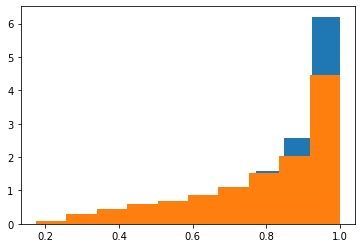

In [640]:
plt.hist(np.amax(rf_grid_search.predict_proba(X_train),axis=1),density=True)
plt.hist(np.amax(rf_grid_search.predict_proba(X_test),axis=1),density = True)

(array([  58.,  213.,  305.,  409.,  475.,  607.,  759., 1064., 1408.,
        3102.]),
 array([0.1746746 , 0.25720714, 0.33973968, 0.42227222, 0.50480476,
        0.5873373 , 0.66986984, 0.75240238, 0.83493492, 0.91746746,
        1.        ]),
 <BarContainer object of 10 artists>)

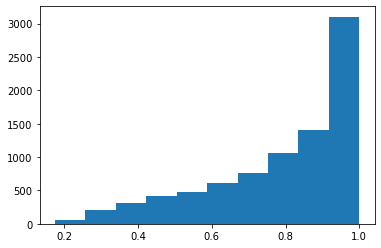

In [573]:
plt.hist(np.amax(rf_grid_search.predict_proba(X_test),axis=1))

In [ ]:
#### We will choose all the data with max classification probability < 0.6 for further fitting with SVM

In [641]:
X_train_svm = X_train[np.amax(rf_grid_search.predict_proba(X_train),axis=1) < 0.8]
y_train_svm = y_train[np.amax(rf_grid_search.predict_proba(X_train),axis=1) < 0.8]
X_test_svm = X_test[np.amax(rf_grid_search.predict_proba(X_test),axis=1) < 0.8]
y_test_svm = y_test[np.amax(rf_grid_search.predict_proba(X_test),axis=1) < 0.8]


In [642]:
print(X_train_svm.shape[0]/X_train.shape[0])
print(X_test_svm.shape[0]/X_test.shape[0])

0.249375
0.4023809523809524


In [643]:
start_time = time.time()
svm_clf = svm.SVC(kernel='rbf')
#r_range =  np.array([0.25,0.5, 1,2,4])
gamma_range =  ['auto','scale']
C_range = [0.01,0.1,1,10,100,1000]
#d_range = np.array([2,3, 4])
param_grid = dict(C = C_range, gamma=gamma_range,probability = [True],class_weight = ['balanced'])
svm_grid_search = GridSearchCV(svm_clf, param_grid, cv=5,n_jobs=-1)
svm_grid_search.fit(X_train_svm, y_train_svm)
best_svm = svm_grid_search.best_params_
print(f"Training Accuracy: {svm_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {svm_grid_search.best_params_}")
#y_hat_test_svm = svm_grid_search.predict(X_test)
#svm_proba_SVD_200 = svm_grid_search.predict_proba(X_test)
#SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test)}
#print(SVM_poly_dict)
print(time.time()-start_time)

/Users/akshayghalsasi/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Accuracy: 86.05%

Optimal Parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'probability': True}
3095.536393880844


In [644]:
y_hat_test_svm = svm_grid_search.predict(X_test_svm)
#svm_proba_SVD_200 = svm_grid_search.predict_proba(X_test_svm)
SVM_poly_dict = {'accuracy':accuracy_score(y_hat_test_svm,y_test_svm)}
print(SVM_poly_dict)


{'accuracy': 0.913905325443787}


(array([  15.,   42.,  117.,  252.,  309.,  618., 1217., 1785., 2114.,
        1910.]),
 array([0.9092622 , 0.91833576, 0.92740933, 0.9364829 , 0.94555646,
        0.95463003, 0.9637036 , 0.97277716, 0.98185073, 0.9909243 ,
        0.99999786]),
 <BarContainer object of 10 artists>)

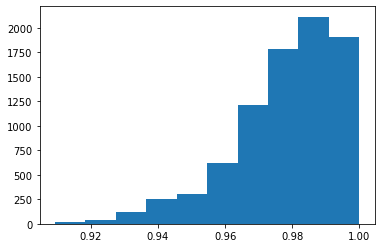

In [645]:
plt.hist(np.amax(svm_grid_search.predict_proba(X_train_svm),axis=1))

(array([  12.,   34.,   56.,  114.,  126.,  115.,  131.,  192.,  385.,
        2215.]),
 array([0.17719656, 0.25947685, 0.34175714, 0.42403744, 0.50631773,
        0.58859802, 0.67087831, 0.7531586 , 0.83543889, 0.91771919,
        0.99999948]),
 <BarContainer object of 10 artists>)

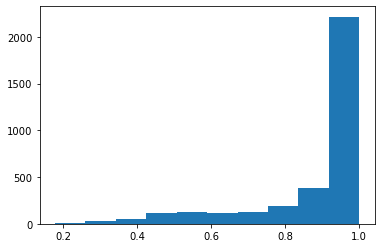

In [646]:
plt.hist(np.amax(svm_grid_search.predict_proba(X_test_svm),axis=1))

In [648]:
y_test_RF = y_test[np.amax(rf_grid_search.predict_proba(X_test),axis=1) >= 0.8]
y_hat_test_RF_only = y_hat_test_RF[np.amax(rf_grid_search.predict_proba(X_test),axis=1) >= 0.8]
RF_accuracy = accuracy_score(y_hat_test_RF_only,y_test_RF)
print(RF_accuracy)

0.999203187250996


In [649]:
SVM_accuracy = accuracy_score(y_hat_test_svm,y_test_svm)
print(SVM_accuracy)

0.913905325443787


In [650]:
tot_accuracy = (RF_accuracy*(y_test_RF.shape[0]) + SVM_accuracy*y_test_svm.shape[0])/(y_test_RF.shape[0] + y_test_svm.shape[0])

In [651]:
tot_accuracy

0.9648809523809524

In [625]:
RF_accuracy*(y_test_RF.shape[0])

6834.0

In [627]:
SVM_accuracy*y_test_svm.shape[0]

1975.0